In [ ]:
# EXECUTAR NO TERMINAL:

# !pip install pandas
# !pip install tensorflow
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib

## BIBLIOTECAS

In [2]:
# Bibliotecas para data-science
import pandas as pd   #Biblioteca para Dataframes
import os   #Biblioteca para acesso dos arquivos
import glob   #Biblioteca para acesso dos arquivos
import numpy as np  #Biblioteca numérica

# Bibliotecas para problemas de otimização
import pyomo.environ as pyo  #Biblioteca para otimização
from amplpy import AMPL

# Bibliotecas para redes neurais
import tensorflow as tf
import h5py
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras import backend as K  #Função para resetar a rede criada

# Bibliotecas gráficas
import matplotlib.pyplot as plt  #Biblioteca para plotar gráfico
from mpl_toolkits.mplot3d import Axes3D #Função para gerar gráfico 3D
from matplotlib.lines import Line2D #Função para gerar a legenda do gráfico com dois eixos Y

# Bibliotecas para medição de tempo
import time

# Possíveis bibliotecas úteis:
import sympy as sp   #Biblioteca simbólica
import scipy as scp  #Biblioteca matemática geral

# PANDAS


## Código Principal

### Definição das Variáveis

Base

In [3]:
# DETERMINAÇÃO DAS TABELAS DA ONS

dir = "I:\\Meu Drive\\Dissertação Yuri\\Dados ONS"


ons = {}
ons_usinas = {}

#Acessar o drive e armazenar os dados
for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
  if len(list(set(os.listdir(f'{dir}\\{i}')) - {'desktop.ini'})) == 1:
    ons[i] = pd.read_csv(glob.glob(f'{dir}\\{i}\\*')[0], delimiter = ";")
  else:
    ons[i] = None

# Concatenar e armazenar os dados disponibilizados de forma mensal
for i in ons.keys():
  tab_temp=[]
  if ons[i] is None:
    for j in range(1,13):
      if os.path.isfile(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv') == True:
        tab_temp.append(pd.read_csv(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv', delimiter = ";"))
        ons[str(i)] = pd.concat(tab_temp)
      else:
        pass
  else:
    pass

  del tab_temp

  #Separação em usinas térmicas
  ons[i] = ons[i].loc[ons[i]['nom_tipousina']=='TÉRMICA']
  ons_usinas[i] = list(set(ons[i]['nom_usina'].values.tolist()))

  #Remover colunas desnecessárias
  ons[i] = ons[i].drop(columns=['id_subsistema',
                          'nom_subsistema',
                          'nom_estado',
                          'cod_modalidadeoperacao',
                          'nom_tipousina',
                          'ceg'])

  #Trocar o nome das colunas restantes
  ons[i] = ons[i].rename(columns={'din_instante':'Dia-Hora',
                            'id_estado':'Estado',
                            'nom_tipocombustivel':'Combustível',
                            'nom_usina':'Usina',
                            'val_geracao':'Geração'})

############################################################################################################

# DETERMINAÇÃO DAS TABELAS DA IEMA
dir = 'I:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

iema = {}
iema_emi_usinas = {}
iema_ger_usinas = {}
sheets = [0,1]

for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
  iema[i] = pd.read_excel(f'{dir}\\{i}\\IEMA {i}.xlsx', sheet_name=sheets)

for i in iema.keys():
  iema_ger_usinas[i] = list(iema[i][0]['Usina'])
  iema_emi_usinas[i] = list(iema[i][1]['Usina'])

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(i,j,dir,arq):
  if os.path.exists(dir):
    if os.path.isfile(f'{dir}/{arq}') == False:
      ons[i].loc[ons[i]['Usina']==ons_usinas[i][j]].to_csv(f'{dir}/{arq}',index=False)
  else:
    os.makedirs(f'{dir}')
    ons[i].loc[ons[i]['Usina']==ons_usinas[i][j]].to_csv(f'{dir}/{arq}',index=False)

for i in ons:
  if i in iema_emi_usinas.keys(): # Apenas gera os dados de geração dos anos equivalente ao último relatório IEMA
    for j in range(len(ons_usinas[i])):
      if ons_usinas[i][j] in iema_emi_usinas[i]:
        dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas[i][j]}\\Dados de Geração'
        arq = f'{ons_usinas[i][j]}_{i}.csv'
        armazenar(i,j,dir,arq)


dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

usinas = list(set(os.listdir(f'{dir}')) - {'desktop.ini'})

############################################################################################################

#COMBINAÇÕES POSSÍVEIS DAS TERMELÉTRICAS

#Gás Natural e Ciclo Combinado
#Gás Natural e Ciclo Brayton
#Gás Natural e Motor Combustão

#Carvão Mineral e Ciclo Rankine

#Óleo Combustível e Motor Combustão

#Óleo Diesel e Motor Combustão
#Óleo Diesel e Ciclo Combinado

#############################################################################################################

### Otimização - AMPL

Base

In [4]:
def ampl_model(iema_ampl, ons_ampl):
    # Criando uma instância AMPL
    ampl_instance = AMPL()

    # Definindo parâmetros
    PG = list(ons_ampl['Geração']) #(dividir por 100 para PU)
    E = iema_ampl['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema_ampl['Usina'] == ons_ampl['Usina'].iloc[0]].values[0] * 1000

    # Definindo o modelo em AMPL
    ampl_instance.eval(r'''
        set intervalos;

        param PG{intervalos};
        param E; # Emissão anual

        var alfa >= 0;
        var beta >= 0;
        var gamma >= 0;
        var omega >= 0;
        var mi >= 0;

        minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2; 
    ''')
    ampl_instance.set['intervalos'] = range(0, len(PG))
    ampl_instance.param['PG'] = PG
    ampl_instance.param['E'] = E

    # Carregando o modelo
    ampl_instance.setOption('solver','C:\\Users\\Yuri_\\OneDrive\\Documents\\Ipopt-3.14.16-win64-msvs2019-md\\bin\\ipopt')  # Instalar o solver ipopt (Disponível em https://github.com/coin-or/Ipopt)
    ampl_instance.solve() 

    # Extraindo resultados
    alfa = ampl_instance.getVariable("alfa").value()
    beta = ampl_instance.getVariable("beta").value()
    gamma = ampl_instance.getVariable("gamma").value()
    omega = ampl_instance.getVariable("omega").value()
    mi = ampl_instance.getVariable("mi").value()

    # Salvando os resultados
    tab = pd.DataFrame({'Coeficientes':['Alfa','Beta','Gamma','Omega','Mi'],'Valores':[alfa,beta,gamma,omega,mi]})
    tab.to_csv(f'{dir2}\\{list(ons_ampl["Usina"])[0]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)

    # Limpando o modelo para disponibilizar armazenamento na memória
    del ampl_instance

# Parâmetros do solver
dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE (ALTERAR A FUNÇÃO OBJETIVO)
pu_mw = 'MW'   # MW / PU  (ALTERAR A FUNÇÃO OBJETIVO)

# Código para somar os dados de emissão IEMA
dir_iema = f'I:\\Meu Drive\\Dissertação Yuri\\Dados IEMA' 
ano = os.listdir(f'{dir_iema}')[0]
iema_ampl = iema[ano][1]
for i in iema.keys():
    if str(int(i)+1) in iema.keys():
        iema_ampl = pd.merge(iema_ampl, iema[str(int(i)+1)][1], how='outer', on='Usina', suffixes=(f'_{i}', f'_{str(int(i)+1)}'))
        iema_ampl.replace(np.nan, 0, inplace=True)
        data = {'Usina': iema_ampl['Usina'].tolist(), 'Gases Emitidos (MIL TONELADAS DE CO2e)': (iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{i}'] + iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{str(int(i)+1)}']).tolist()}
        iema_ampl = pd.DataFrame(data)

# Código para concatenar os dados de geração ONS e realizar a otimização
for i in usinas:
    path = f'{dir}\\{i}\\Dados de Geração\\'
    csv_files = glob.glob(f'{path}*.csv')
    
    if not csv_files:
        print(f"Nenhum arquivo CSV encontrado em {path}")
        continue
    
    print(f"Arquivos encontrados em {path}: {csv_files}")
    ons_ampl = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)
    
    if zeros == 'com_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
        ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]   # DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
    
    if list(ons_ampl['Usina'])[0] in list(iema_ampl['Usina']):
        dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
        if not os.path.exists(dir2):
            os.makedirs(dir2)
        if not os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
            ampl_model(iema_ampl, ons_ampl)

Arquivos encontrados em I:\Meu Drive\Dissertação Yuri\ONS Termeletricas\J. Lacerda C\Dados de Geração\: ['I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\J. Lacerda C\\Dados de Geração\\J. Lacerda C_2020.csv', 'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\J. Lacerda C\\Dados de Geração\\J. Lacerda C_2021.csv', 'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\J. Lacerda C\\Dados de Geração\\J. Lacerda C_2022.csv']
Arquivos encontrados em I:\Meu Drive\Dissertação Yuri\ONS Termeletricas\Santa Cruz\Dados de Geração\: ['I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\Santa Cruz\\Dados de Geração\\Santa Cruz_2020.csv', 'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\Santa Cruz\\Dados de Geração\\Santa Cruz_2021.csv', 'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\Santa Cruz\\Dados de Geração\\Santa Cruz_2022.csv', 'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\Santa Cruz\\Dados de Geração\\Dados_Geracao_Com_Emissao.csv']
Arquivos encontrados em I:\Meu Driv

### Criação das Emissões Sintéticas

Base

In [5]:
# CÓDIGO QUE CALCULA AS EMISSÕES ANUAIS DOS ANOS APRESENTADOS NO IEMA

def em_sint(j,arq):
  PG = list(arq['Geração'])
  em = []

  dir2 = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usinas[j]}\\Coeficientes\\AMPL\\Dados Concatenados'
  if os.path.isfile(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv') == True:
    tab = pd.read_csv(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')

    alfa = tab['Valores'].loc[tab['Coeficientes'] == 'Alfa'].item()
    beta = tab['Valores'].loc[tab['Coeficientes'] == 'Beta'].item()
    gamma = tab['Valores'].loc[tab['Coeficientes'] == 'Gamma'].item()
    omega = tab['Valores'].loc[tab['Coeficientes'] == 'Omega'].item()
    mi = tab['Valores'].loc[tab['Coeficientes'] == 'Mi'].item()

    for k in range(len(PG)):
      em.append((alfa * PG[k]**2 + beta * PG[k] + gamma) + omega * np.exp(mi * PG[k]))

    data={
      'Dia-Hora': list(arq['Dia-Hora']),
      'Combustível': list(arq['Combustível']),
      'Usina': list(arq['Usina']),
      'Emissão': em
    }

    df = pd.DataFrame(data)
    df.to_csv(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv',index=False)


zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
pu_mw = 'MW'   # MW / PU

for i in ons:
  if i in iema_emi_usinas.keys():
    for j in range(len(usinas)):
      if usinas[j] in iema_emi_usinas[i]:
        arq = ons[i].loc[ons[i]['Usina']==usinas[j]]
        if arq.empty == False:
          dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usinas[j]}\\Dados de Emissão (Sintético)\\AMPL\\{i}'
          if os.path.exists(dir):
            if os.path.isfile(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv') == False:
              em_sint(j,arq)
          else:
            os.makedirs(f'{dir}')
            em_sint(j,arq)

### Tratamento dos Dados - Geral

Base

In [6]:
temp = []
for i in usinas:
  dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{i}\\Dados de Geração'
  for j in iema.keys():
    if os.path.isfile(f'{dir}\\{i}_{j}.csv'):
      temp.append(pd.read_csv(f'{dir}\\{i}_{j}.csv'))
      tab_temp = pd.concat(temp)

temp = []
for i in iema:
    temp.append(iema[i][1])
    iema_temp = pd.concat(temp)

iema_temp = iema_temp.drop_duplicates(subset='Usina')

temp = pd.merge(tab_temp,iema_temp,how='left',on='Usina')

data = {
    'Usina':temp['Usina'],
    'Geração':temp['Geração'],
    'Combustível':temp['Combustível_x'],
    'Ciclo de Operação':temp['Ciclo de Operação'],
    'Potência Instalada': temp['Potência Instalada (MW)']
}

temp = pd.DataFrame(data)
temp = temp.dropna(subset='Ciclo de Operação')

ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),['Combustível','Ciclo de Operação'])],remainder='passthrough')
x=ct.fit_transform(temp)

colunas = ['ohe1','ohe2','ohe3','ohe4','ohe5','ohe6','ohe7','ohe8','Usina','Geração','Potência Instalada']

tab_trat = pd.DataFrame(x,columns=colunas)

### Tratamento dos Dados - Específico

Base

In [7]:
usina = input('Insira a usina a ser analisada:')  #Para utilizar os dados de todas as usinas, deixar em branco
zeros = 'com_zeros'

usina_serie = tab_trat['Usina']
#tab_trat_usina = tab_trat.loc[tab_trat['Usina'] == usina]

temp = []
if usina == '':
    for i in usinas:
        dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{i}\\Dados de Emissão (Sintético)\\AMPL'
        for j in iema.keys():
            if os.path.isfile(f'{dir}\\{j}\\{i}_MSE_MW_{zeros}.csv'):
                temp.append(pd.read_csv(f'{dir}/{j}/{i}_MSE_MW_{zeros}.csv'))
                emi = pd.concat(temp)
else:
    dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Dados de Emissão (Sintético)\\AMPL'
    for i in iema.keys():
        if os.path.isfile(f'{dir}/{i}/{usina}_MSE_MW_{zeros}.csv'):
            temp.append(pd.read_csv(f'{dir}/{i}/{usina}_MSE_MW_{zeros}.csv'))
            emi = pd.concat(temp)


x = tab_trat[['ohe1','ohe2','ohe3','ohe4','ohe5','ohe6','ohe7','ohe8','Geração','Potência Instalada']]

# Definição das variáveis de treino e teste
sc = StandardScaler() # Transforma variáveis categóricas em numéricas
x = sc.fit_transform(x)
x = pd.DataFrame({'Coluna1': x[:, 0], 'Coluna2': x[:, 1], 'Coluna3': x[:, 2], 'Coluna4':x[:, 3], 'Coluna5':x[:, 4], 'Coluna6':x[:, 5], 'Coluna7':x[:, 6], 'Coluna8':x[:, 7], 'Geração':x[:, 8], 'Potência Instalada':x[:, 9], 'Usina':usina_serie})
x = x.loc[x['Usina'] == usina] if usina != '' else x
x = x.drop(['Usina'],axis=1)

y = emi['Emissão']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

### Criação Rede Neural

Base

In [8]:
K.clear_session()   #Limpar redes geradas anteriormente
rede = tf.keras.Sequential()

if usina == '': #EM TESTE
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(128,activation='relu'))
    rede.add(tf.keras.layers.Dense(1))

else:
    rede.add(tf.keras.layers.Dense(64,activation='relu'))
    rede.add(tf.keras.layers.Dense(64,activation='relu'))
    rede.add(tf.keras.layers.Dense(64,activation='relu'))
    rede.add(tf.keras.layers.Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
rede.compile(optimizer=opt, loss='mean_squared_error')

### Treino e Execução da Rede Neural

Base

In [9]:
# Inicializa a medição do erro quadrático médio MSE 
mse = tf.keras.metrics.MeanSquaredError()


# While para treinar a rede N vezes até atingir um erro satisfatório
tic = time.time()
i=0
while True:
    i+=1
    rede.fit(x_train,y_train,epochs=2000,verbose=0) #100 a 2000 epochs
    y_pred = rede.predict(x_train)

    mse.update_state(y_train, y_pred)
    mse_result = mse.result().numpy()
    print(f'MSE Geração {i}: {mse_result}')
    if mse_result < 20:
        tac = time.time()
        break
tempo_exec = tac - tic
print(f'\nTempo de Execução: {tempo_exec}')

#Salvar os pesos no diretório
if usina == '':
    dir = 'I:\\Meu Drive\\Dissertação Yuri\\Python\\Codigo'
    
    rede.save_weights(f'{dir}\\Pesos_Geral.weights.h5')
else:
    dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Pesos'
    if os.path.exists(dir):
        if os.path.isfile(f'{dir}\\{usina}.weights.h5') == False:
            rede.save_weights(f'{dir}\\{usina}.weights.h5')
    else:
        os.makedirs(f'{dir}')
        rede.save_weights(f'{dir}\\{usina}.weights.h5')

658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step
MSE Geração 1: 0.00013184432464186102

Tempo de Execução: 1655.447857618332


### Execução da Rede à Partir de Pesos Salvos

Base

In [11]:
# Inicializa a medição do erro quadrático médio
mse = tf.keras.metrics.MeanSquaredError()

# Carregar os pesos
dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}/Pesos'
rede.load_weights(f'{dir}/{usina}.weights.h5')

# Executa a rede
y_pred = rede.predict(x_train)

mse.update_state(y_train, y_pred)
mse_result = mse.result().numpy()
print(f'MSE Geração {i}: {mse_result}')

658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE Geração 1: 3185.792236328125


## Gráficos

### Gráficos 2D

Base

Regressão Aparecida (MSE: 3185.7922)


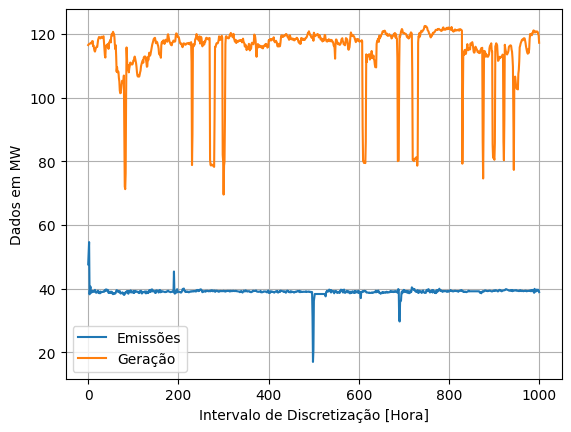

In [12]:
# Verifique se há dados suficientes para plotar
if len(y_test) > 0 and len(tab_trat['Geração'].loc[tab_trat['Usina'] == usina]) > 0:
    # Criação da variável x_fig
    x_fig = np.linspace(0, len(y_test), len(y_test))
    tempo_inicio = 0
    tempo_fim = min(1000, len(y_test), len(tab_trat['Geração'].loc[tab_trat['Usina'] == usina]))

    plt.figure()
    plt.plot(x_fig[tempo_inicio:tempo_fim], y_test[tempo_inicio:tempo_fim], 
             x_fig[tempo_inicio:tempo_fim], tab_trat['Geração'].loc[tab_trat['Usina'] == usina].values[tempo_inicio:tempo_fim])
    plt.legend(['Emissões', 'Geração'])
    plt.xlabel('Intervalo de Discretização [Hora]')
    plt.ylabel('Dados em MW')
    plt.grid()
    if usina != '':
        print(f'Regressão {usina} (MSE: {mse.result().numpy():.4f})')
    else:
        print('Regressão de todas as usinas')
    plt.show()
else:
    print("Não há dados suficientes para plotar o gráfico.")

Base

Gráfico referente à usina Aparecida



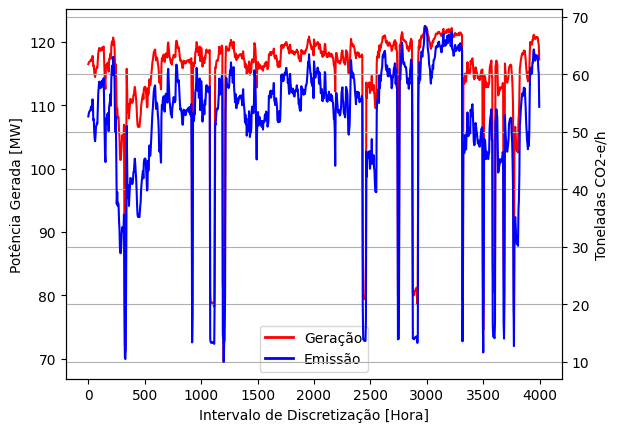

In [13]:
# Gráfico com dois eixos Y

x_fig = np.linspace(0,len(y_pred),len(x_test))
tempo_inicio = 0
tempo_fim = 1000

fig,ax1 = plt.subplots()

ax1.set_xlabel('Intervalo de Discretização [Hora]')
ax1.set_ylabel('Potência Gerada [MW]')
ax1.plot(x_fig[tempo_inicio:tempo_fim],tab_trat['Geração'].loc[tab_trat['Usina'] == usina][tempo_inicio:tempo_fim],color='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Toneladas CO2-e/h')
ax2.plot(x_fig[tempo_inicio:tempo_fim],y_pred[tempo_inicio:tempo_fim],color='b')
ax2.grid()

# Adicionando legendas personalizadas
legend_elements = [
    Line2D([0], [0], color='r', lw=2, label='Geração'),
    Line2D([0], [0], color='b', lw=2, label='Emissão')]

# Unindo as legendas
ax1.legend(handles=legend_elements, loc='best')

print(f'Gráfico referente à usina {usina}\n') if usina != '' else print('Gráfico referente à todas as usinas')
plt.show()

Validação da Regressão 

Base (Tratativa de dados)

In [14]:
# DETERMINAÇÃO DAS TABELAS DA ONS

dir = "I:\\Meu Drive\\Dissertação Yuri\\Dados ONS"

ons = {}
ons_usinas = {}

# Acessar o drive e armazenar os dados
for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
    if i not in ['2020', '2021']:
        continue  # Considerar apenas os anos 2020 e 2021
    if len(list(set(os.listdir(f'{dir}\\{i}')) - {'desktop.ini'})) == 1:
        ons[i] = pd.read_csv(glob.glob(f'{dir}\\{i}\\*')[0], delimiter=";")
    else:
        ons[i] = None

# Concatenar e armazenar os dados disponibilizados de forma mensal
for i in ons.keys():
    tab_temp = []
    if ons[i] is None:
        for j in range(1, 13):
            if os.path.isfile(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv'):
                tab_temp.append(pd.read_csv(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv', delimiter=";"))
        if tab_temp:
            ons[str(i)] = pd.concat(tab_temp)
    del tab_temp

    # Separação em usinas térmicas
    ons[i] = ons[i].loc[ons[i]['nom_tipousina'] == 'TÉRMICA']
    ons_usinas[i] = list(set(ons[i]['nom_usina'].values.tolist()))

    # Remover colunas desnecessárias
    ons[i] = ons[i].drop(columns=['id_subsistema', 'nom_subsistema', 'nom_estado', 'cod_modalidadeoperacao', 'nom_tipousina', 'ceg'])

    # Trocar o nome das colunas restantes
    ons[i] = ons[i].rename(columns={'din_instante': 'Dia-Hora', 'id_estado': 'Estado', 'nom_tipocombustivel': 'Combustível', 'nom_usina': 'Usina', 'val_geracao': 'Geração'})

############################################################################################################

# DETERMINAÇÃO DAS TABELAS DA IEMA
dir = 'I:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

iema = {}
iema_emi_usinas = {}
iema_ger_usinas = {}
sheets = [0, 1]

for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
    if i not in ['2020', '2021']:
        continue  # Considerar apenas os anos 2020 e 2021
    iema[i] = pd.read_excel(f'{dir}\\{i}\\IEMA {i}.xlsx', sheet_name=sheets)

for i in iema.keys():
    iema_ger_usinas[i] = list(iema[i][0]['Usina'])
    iema_emi_usinas[i] = list(iema[i][1]['Usina'])

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(i, j, dir, arq):
    if os.path.exists(dir):
        if not os.path.isfile(f'{dir}/{arq}'):
            ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)
    else:
        os.makedirs(dir)
        ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)

for i in ons:
    if i in iema_emi_usinas.keys():  # Apenas gera os dados de geração dos anos equivalente ao último relatório IEMA
        for j in range(len(ons_usinas[i])):
            if ons_usinas[i][j] in iema_emi_usinas[i]:
                dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas[i][j]}\\Dados de Geração'
                arq = f'{ons_usinas[i][j]}_{i}.csv'
                armazenar(i, j, dir, arq)

dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

usinas = list(set(os.listdir(f'{dir}')) - {'desktop.ini'})

############################################################################################################

# COMBINAÇÕES POSSÍVEIS DAS TERMELÉTRICAS

# Gás Natural e Ciclo Combinado
# Gás Natural e Ciclo Brayton
# Gás Natural e Motor Combustão

# Carvão Mineral e Ciclo Rankine

# Óleo Combustível e Motor Combustão

# Óleo Diesel e Motor Combustão
# Óleo Diesel e Ciclo Combinado

#############################################################################################################

def ampl_model(iema_ampl, ons_ampl):
    # Criando uma instância AMPL
    ampl_instance = AMPL()

    # Definindo parâmetros
    PG = list(ons_ampl['Geração'])  # (dividir por 100 para PU)
    E = iema_ampl['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema_ampl['Usina'] == ons_ampl['Usina'].iloc[0]].values[0] * 1000

    # Definindo o modelo em AMPL
    ampl_instance.eval(r'''
        set intervalos;

        param PG{intervalos};
        param E; # Emissão anual

        var alfa >= 0;
        var beta >= 0;
        var gamma >= 0;
        var omega >= 0;
        var mi >= 0;

        minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2; 
    ''')

    ampl_instance.set['intervalos'] = range(0, len(PG))
    ampl_instance.param['PG'] = PG
    ampl_instance.param['E'] = E

    # Carregando o modelo
    ampl_instance.setOption('solver', 'C:\\Users\\Yuri_\\OneDrive\\Documents\\Ipopt-3.14.16-win64-msvs2019-md\\bin\\ipopt')  # Instalar o solver ipopt (Disponível em https://github.com/coin-or/Ipopt)
    ampl_instance.solve()

    # Extraindo resultados
    alfa = ampl_instance.getVariable("alfa").value()
    beta = ampl_instance.getVariable("beta").value()
    gamma = ampl_instance.getVariable("gamma").value()
    omega = ampl_instance.getVariable("omega").value()
    mi = ampl_instance.getVariable("mi").value()

    # Salvando os resultados
    tab = pd.DataFrame({'Coeficientes': ['Alfa', 'Beta', 'Gamma', 'Omega', 'Mi'], 'Valores': [alfa, beta, gamma, omega, mi]})
    tab.to_csv(f'{dir2}\\{list(ons_ampl['Usina'])[0]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)

    # Limpando o modelo para disponibilizar armazenamento na memória
    del ampl_instance

###############################################################################################################################

# Parâmetros do solver
dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE (ALTERAR A FUNÇÃO OBJETIVO)
pu_mw = 'MW'  # MW / PU  (ALTERAR A FUNÇÃO OBJETIVO)

###############################################################################################################################

# Código para somar os dados de emissão IEMA
dir_iema = f'I:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'
ano = os.listdir(f'{dir_iema}')[0]
iema_ampl = iema[ano][1]
for i in iema.keys():
    if str(int(i) + 1) in iema.keys():
        iema_ampl = pd.merge(iema_ampl, iema[str(int(i) + 1)][1], how='outer', on='Usina', suffixes=(f'_{i}', f'_{str(int(i) + 1)}'))
        iema_ampl.replace(np.nan, 0, inplace=True)
        data = {'Usina': iema_ampl['Usina'].tolist(), 'Gases Emitidos (MIL TONELADAS DE CO2e)': (iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{i}'] + iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{str(int(i) + 1)}']).tolist()}
        iema_ampl = pd.DataFrame(data)

# Código para concatenar os dados de geração ONS e realizar a otimização
for i in usinas:
    files = glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv')
    if files:
        ons_ampl = pd.concat(map(pd.read_csv, files))  # Código para concatenar os dados de geração ONS
        if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
            ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]  # DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
        if list(ons_ampl['Usina'])[0] in list(iema_ampl['Usina']):
            dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
            if os.path.exists(dir2):
                if not os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                    ampl_model(iema_ampl, ons_ampl)
            else:
                os.makedirs(dir2)
                ampl_model(iema_ampl, ons_ampl)

# CÓDIGO QUE CALCULA AS EMISSÕES ANUAIS DOS ANOS APRESENTADOS NO IEMA

def em_sint(j, arq):
    PG = list(arq['Geração'])
    em = []

    dir2 = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usinas[j]}\\Coeficientes\\AMPL\\Dados Concatenados'
    if os.path.isfile(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
        tab = pd.read_csv(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')

        alfa = tab['Valores'].loc[tab['Coeficientes'] == 'Alfa'].item()
        beta = tab['Valores'].loc[tab['Coeficientes'] == 'Beta'].item()
        gamma = tab['Valores'].loc[tab['Coeficientes'] == 'Gamma'].item()
        omega = tab['Valores'].loc[tab['Coeficientes'] == 'Omega'].item()
        mi = tab['Valores'].loc[tab['Coeficientes'] == 'Mi'].item()

        for k in range(len(PG)):
            em.append((alfa * PG[k]**2 + beta * PG[k] + gamma) + omega * np.exp(mi * PG[k]))

        data = {
            'Dia-Hora': list(arq['Dia-Hora']),
            'Combustível': list(arq['Combustível']),
            'Usina': list(arq['Usina']),
            'Emissão': em
        }

        df = pd.DataFrame(data)
        df.to_csv(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)

zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
pu_mw = 'MW'  # MW / PU

# TRATATIVA ESPECÍFICA PARA 2022
if '2022' in os.listdir(dir):
    # Processar dados de 2022
    ons['2022'] = pd.read_csv(glob.glob(f'{dir}\\2022\\*')[0], delimiter=";")
    tab_temp = []
    for j in range(1, 13):
        if os.path.isfile(f'{dir}\\2022\\GERACAO_USINA-2_2022_{j}.csv'):
            tab_temp.append(pd.read_csv(f'{dir}\\2022\\GERACAO_USINA-2_2022_{j}.csv', delimiter=";"))
    if tab_temp:
        ons['2022'] = pd.concat(tab_temp)

    ons['2022'] = ons['2022'].loc[ons['2022']['nom_tipousina'] == 'TÉRMICA']
    ons_usinas['2022'] = list(set(ons['2022']['nom_usina'].values.tolist()))
    ons['2022'] = ons['2022'].drop(columns=['id_subsistema', 'nom_subsistema', 'nom_estado', 'cod_modalidadeoperacao', 'nom_tipousina', 'ceg'])
    ons['2022'] = ons['2022'].rename(columns={'din_instante': 'Dia-Hora', 'id_estado': 'Estado', 'nom_tipocombustivel': 'Combustível', 'nom_usina': 'Usina', 'val_geracao': 'Geração'})

    # Processar dados IEMA de 2022
    iema['2022'] = pd.read_excel(f'{dir_iema}\\2022\\IEMA 2022.xlsx', sheet_name=sheets)
    iema_ger_usinas['2022'] = list(iema['2022'][0]['Usina'])
    iema_emi_usinas['2022'] = list(iema['2022'][1]['Usina'])
    
    # Armazenar dados de geração para 2022
    for j in range(len(ons_usinas['2022'])):
        if ons_usinas['2022'][j] in iema_emi_usinas['2022']:
            dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas["2022"][j]}\\Dados de Geração'
            arq = f'{ons_usinas["2022"][j]}_2022.csv'
            armazenar('2022', j, dir, arq)

    # Código para concatenar os dados de geração ONS de 2022 e realizar a otimização
    for i in usinas:
        if i in ons_usinas['2022']:
            files = glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv')
            if files:
                ons_ampl = pd.concat(map(pd.read_csv, files))  # Código para concatenar os dados de geração ONS
                if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
                    ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]  # DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
                if list(ons_ampl['Usina'])[0] in list(iema['2022'][1]['Usina']):
                    dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
                    if os.path.exists(dir2):
                        if not os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                            ampl_model(iema['2022'][1], ons_ampl)
                    else:
                        os.makedirs(dir2)
                        ampl_model(iema['2022'][1], ons_ampl)

    # CÓDIGO QUE CALCULA AS EMISSÕES ANUAIS DOS DADOS DE 2022
    for j in range(len(usinas)):
        if usinas[j] in iema_emi_usinas['2022']:
            arq = ons['2022'].loc[ons['2022']['Usina'] == usinas[j]]
            if not arq.empty:
                dir = f'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usinas[j]}\\Dados de Emissão (Sintético)\\AMPL\\2022'
                if os.path.exists(dir):
                    if not os.path.isfile(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                        em_sint(j, arq)
                else:
                    os.makedirs(dir)
                    em_sint(j, arq)


Carregar Coeficientes

In [15]:
# Função para carregar coeficientes
def carregar_coeficientes(diretorio, usina, metodo_objetivo, pu_mw, zeros):
    arquivo_coeficientes = glob.glob(f'{diretorio}\\{usina}\\Coeficientes\\AMPL\\Dados Concatenados\\{usina}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')[0]
    coeficientes_df = pd.read_csv(arquivo_coeficientes)
    coeficientes = {row['Coeficientes']: row['Valores'] for index, row in coeficientes_df.iterrows()}
    return coeficientes

# Função para calcular emissões
def calcular_emissao(df, coeficientes):
    alfa = coeficientes.get('Alfa', 0)
    beta = coeficientes.get('Beta', 0)
    gamma = coeficientes.get('Gamma', 0)
    omega = coeficientes.get('Omega', 0)
    mi = coeficientes.get('Mi', 0)
    
    # Aplicar a função para calcular as emissões
    df['Emissao Calculada'] = alfa * df['Geração']**2 + beta * df['Geração'] + gamma + omega * np.exp(mi * df['Geração'])
    df['Emissao Calculada (MIL TON)'] = df['Emissao Calculada'] / 1000  # Convertendo para mil toneladas de CO2
    return df

# Função para carregar as emissões do IEMA para 2022
def carregar_emissao_iema_2022(dir_iema, usina):
    arquivo_iema_2022 = f'{dir_iema}\\2022\\IEMA 2022.xlsx'
    iema_2022 = pd.read_excel(arquivo_iema_2022, sheet_name=1)
    if usina in iema_2022['Usina'].values:
        return iema_2022.loc[iema_2022['Usina'] == usina, 'Gases Emitidos (MIL TONELADAS DE CO2e)'].values[0]
    return None

# Diretórios e parâmetros
diretorio_coeficientes = 'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
metodo_objetivo = 'MSE'  # Método objetivo usado
pu_mw = 'MW'  # Unidade de potência
zeros = 'com_zeros'  # Considerar geração zero

# Diretório dos dados de emissão do IEMA
dir_iema = 'I:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

# Solicitar ao usuário o nome da usina
usinas = list(set(os.listdir(f'{diretorio_coeficientes}')) - {'desktop.ini'})
print("Usinas disponíveis:")
for usina in usinas:
    print(usina)

usina_selecionada = input("Digite o nome da usina desejada: ")

# Verificar se a usina selecionada é válida
if usina_selecionada not in usinas:
    raise ValueError(f"Usina '{usina_selecionada}' não encontrada. Verifique o nome e tente novamente.")

# Carregar coeficientes
coeficientes = carregar_coeficientes(diretorio_coeficientes, usina_selecionada, metodo_objetivo, pu_mw, zeros)

# Diretório dos dados de geração para 2022
diretorio_geracao = f'{diretorio_coeficientes}\\{usina_selecionada}\\Dados de Geração'
arquivo_geracao = glob.glob(f'{diretorio_geracao}\\*2022*.csv')[0]
dados_geracao = pd.read_csv(arquivo_geracao)

# Verificar se os dados de geração foram carregados corretamente
if dados_geracao.empty:
    raise ValueError(f"Não foi possível encontrar dados de geração para a usina {usina_selecionada} em 2022.")

# Calcular emissão
dados_geracao_com_emissao = calcular_emissao(dados_geracao, coeficientes)

# Carregar emissões do IEMA para 2022
emissao_iema_2022 = carregar_emissao_iema_2022(dir_iema, usina_selecionada)
if emissao_iema_2022 is None:
    raise ValueError(f"Dados de emissão do IEMA não encontrados para a usina {usina_selecionada} em 2022.")

# Calcular erro percentual
emissao_calculada_total = dados_geracao_com_emissao['Emissao Calculada (MIL TON)'].sum()
erro_percentual = abs(emissao_calculada_total - emissao_iema_2022) / emissao_iema_2022 * 100

# Salvar os dados com a nova coluna de emissões calculadas
arquivo_saida = f'{diretorio_geracao}\\Dados_Geracao_Com_Emissao.csv'
dados_geracao_com_emissao.to_csv(arquivo_saida, index=False)

# Exibir o resultado
print(f"Emissão total calculada para a usina {usina_selecionada} em 2022: {emissao_calculada_total:.2f} mil toneladas de CO2")
print(f"Emissão reportada pelo IEMA para a usina {usina_selecionada} em 2022: {emissao_iema_2022:.2f} mil toneladas de CO2")
print(f"Erro percentual: {erro_percentual:.2f}%")

print("Processamento concluído.")

Usinas disponíveis:
J. Lacerda C
Santa Cruz
Três Lagoas
Potiguar
Campina Grande
Geramar II
Araucária
Canoas
Porto do Pecém I
Norte Fluminense
Parnaíba 5
Termonordeste
Nova Piratininga
Potiguar III
Karkey 013
Porto do Itaqui
Baixada Fluminense
Termocabo
Tambaqui
Porto de Sergipe I
Mauá 3
U-50
Manauara
Viana
Termobahia
Ibirité
Global II
Nome_da_Usina
Prosperidade I
Santa Rita
Candiota III
Jaraqui
Vale do Açú
GNA I
Global I
Pau Ferro I
Juiz de Fora
Luiz O. R. Melo
Cristiano Rocha
Seropédica
Termoceará
Termonorte II
Figueira
Ponta Negra
Termopernambuco
Porsud II
Termonorte 1
Porto do Pecém II
Parnaíba IV
Maracanaú I
Termomanaus
Termorio
Viana 1
Karkey 019
Termomacaé
Pampa Sul
Barra Bonita I
Santana II
Geramar I
Santana
Termocamaçari
Palmeiras de Goiás
Cubatão
Pernambuco III
Suape II
Termoparaíba
Cuiabá
Fortaleza
Goiânia II
Aparecida
Maranhão 3
Povoação 1
Petrolina
Porsud I
Uruguaiana
Emissão total calculada para a usina Aparecida em 2022: 282.86 mil toneladas de CO2
Emissão reportada pelo 

Gerar Grafico

Usinas disponíveis:
J. Lacerda C
Santa Cruz
Três Lagoas
Potiguar
Campina Grande
Geramar II
Araucária
Canoas
Porto do Pecém I
Norte Fluminense
Parnaíba 5
Termonordeste
Nova Piratininga
Potiguar III
Karkey 013
Porto do Itaqui
Baixada Fluminense
Termocabo
Tambaqui
Porto de Sergipe I
Mauá 3
U-50
Manauara
Viana
Termobahia
Ibirité
Global II
Nome_da_Usina
Prosperidade I
Santa Rita
Candiota III
Jaraqui
Vale do Açú
GNA I
Global I
Pau Ferro I
Juiz de Fora
Luiz O. R. Melo
Cristiano Rocha
Seropédica
Termoceará
Termonorte II
Figueira
Ponta Negra
Termopernambuco
Porsud II
Termonorte 1
Porto do Pecém II
Parnaíba IV
Maracanaú I
Termomanaus
Termorio
Viana 1
Karkey 019
Termomacaé
Pampa Sul
Barra Bonita I
Santana II
Geramar I
Santana
Termocamaçari
Palmeiras de Goiás
Cubatão
Pernambuco III
Suape II
Termoparaíba
Cuiabá
Fortaleza
Goiânia II
Aparecida
Maranhão 3
Povoação 1
Petrolina
Porsud I
Uruguaiana
Emissão total calculada para a usina Aparecida em 2022: 282.86 mil toneladas de CO2
Emissão reportada pelo 

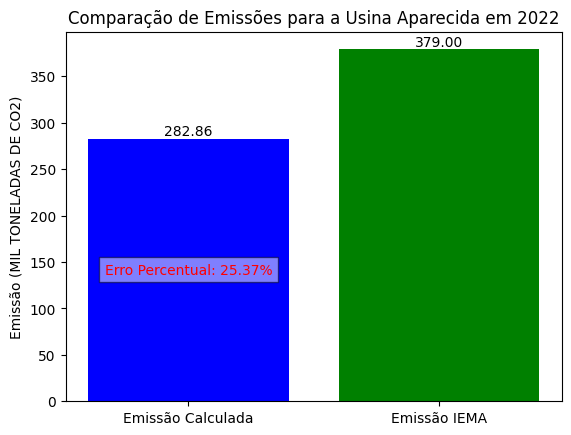

Processamento concluído.

Coeficientes carregados do modelo AMPL:
  Alfa: 0.000985
  Beta: 0.102482
  Gamma: 10.474509
  Omega: 3.833620
  Mi: 0.009629

MSE baseado na emissão total anual (MIL TON)^2: 9243.568098

Coeficientes carregados do modelo AMPL:
  Alfa: 0.000985
  Beta: 0.102482
  Gamma: 10.474509
  Omega: 3.833620
  Mi: 0.009629

Erro quadrado total (entre total calculado e IEMA) (MIL TON)^2: 9243.568098
Pseudo-MSE horário estimado (MIL TON)^2/h: 1.055202


In [18]:
# Função para carregar coeficientes
def carregar_coeficientes(diretorio, usina, metodo_objetivo, pu_mw, zeros):
    arquivo_coeficientes = glob.glob(f'{diretorio}\\{usina}\\Coeficientes\\AMPL\\Dados Concatenados\\{usina}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')[0]
    coeficientes_df = pd.read_csv(arquivo_coeficientes)
    coeficientes = {row['Coeficientes']: row['Valores'] for index, row in coeficientes_df.iterrows()}
    return coeficientes

# Função para calcular emissões
def calcular_emissao(df, coeficientes):
    alfa = coeficientes.get('Alfa', 0)
    beta = coeficientes.get('Beta', 0)
    gamma = coeficientes.get('Gamma', 0)
    omega = coeficientes.get('Omega', 0)
    mi = coeficientes.get('Mi', 0)
    
    # Aplicar a função para calcular as emissões
    df['Emissao Calculada'] = alfa * df['Geração']**2 + beta * df['Geração'] + gamma + omega * np.exp(mi * df['Geração'])
    df['Emissao Calculada (MIL TON)'] = df['Emissao Calculada'] / 1000  # Convertendo para mil toneladas de CO2
    return df

# Função para carregar as emissões do IEMA para 2022
def carregar_emissao_iema_2022(dir_iema, usina):
    arquivo_iema_2022 = f'{dir_iema}\\2022\\IEMA 2022.xlsx'
    iema_2022 = pd.read_excel(arquivo_iema_2022, sheet_name=1)
    if usina in iema_2022['Usina'].values:
        return iema_2022.loc[iema_2022['Usina'] == usina, 'Gases Emitidos (MIL TONELADAS DE CO2e)'].values[0]
    return None

# Diretórios e parâmetros
diretorio_coeficientes = 'I:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
metodo_objetivo = 'MSE'  # Método objetivo usado
pu_mw = 'MW'  # Unidade de potência
zeros = 'com_zeros'  # Considerar geração zero

# Diretório dos dados de emissão do IEMA
dir_iema = 'I:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

# Solicitar ao usuário o nome da usina
usinas = list(set(os.listdir(f'{diretorio_coeficientes}')) - {'desktop.ini'})
print("Usinas disponíveis:")
for usina in usinas:
    print(usina)

usina_selecionada = input("Digite o nome da usina desejada: ")

# Verificar se a usina selecionada é válida
if usina_selecionada not in usinas:
    raise ValueError(f"Usina '{usina_selecionada}' não encontrada. Verifique o nome e tente novamente.")

# Carregar coeficientes
coeficientes = carregar_coeficientes(diretorio_coeficientes, usina_selecionada, metodo_objetivo, pu_mw, zeros)

# Diretório dos dados de geração para 2022
diretorio_geracao = f'{diretorio_coeficientes}\\{usina_selecionada}\\Dados de Geração'
arquivo_geracao = glob.glob(f'{diretorio_geracao}\\*2022*.csv')[0]
dados_geracao = pd.read_csv(arquivo_geracao)

# Verificar se os dados de geração foram carregados corretamente
if dados_geracao.empty:
    raise ValueError(f"Não foi possível encontrar dados de geração para a usina {usina_selecionada} em 2022.")

# Calcular emissão
dados_geracao_com_emissao = calcular_emissao(dados_geracao, coeficientes)

# Carregar emissões do IEMA para 2022
emissao_iema_2022 = carregar_emissao_iema_2022(dir_iema, usina_selecionada)
if emissao_iema_2022 is None:
    raise ValueError(f"Dados de emissão do IEMA não encontrados para a usina {usina_selecionada} em 2022.")

# Calcular erro percentual
emissao_calculada_total = dados_geracao_com_emissao['Emissao Calculada (MIL TON)'].sum()
erro_percentual = abs(emissao_calculada_total - emissao_iema_2022) / emissao_iema_2022 * 100

# Salvar os dados com a nova coluna de emissões calculadas
arquivo_saida = f'{diretorio_geracao}\\Dados_Geracao_Com_Emissao.csv'
dados_geracao_com_emissao.to_csv(arquivo_saida, index=False)

# Exibir o resultado
print(f"Emissão total calculada para a usina {usina_selecionada} em 2022: {emissao_calculada_total:.2f} mil toneladas de CO2")
print(f"Emissão reportada pelo IEMA para a usina {usina_selecionada} em 2022: {emissao_iema_2022:.2f} mil toneladas de CO2")
print(f"Erro percentual: {erro_percentual:.2f}%")

# Visualização gráfica
labels = ['Emissão Calculada', 'Emissão IEMA']
valores = [emissao_calculada_total, emissao_iema_2022]

fig, ax = plt.subplots()
ax.bar(labels, valores, color=['blue', 'green'])
ax.set_ylabel('Emissão (MIL TONELADAS DE CO2)')
ax.set_title(f'Comparação de Emissões para a Usina {usina_selecionada} em 2022')

# Adicionar o erro percentual ao gráfico
for i, v in enumerate(valores):
    ax.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom')
    if i == 0:
        ax.text(i, v / 2, f"Erro Percentual: {erro_percentual:.2f}%", ha='center', va='center', color='red', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

print("Processamento concluído.")

# Printar os coeficientes carregados
print("\nCoeficientes carregados do modelo AMPL:")
for nome, valor in coeficientes.items():
    print(f"  {nome}: {valor:.6f}")

# Calcular e exibir o MSE com base nos totais anuais (emissão real vs. calculada)
mse_total = (emissao_calculada_total - emissao_iema_2022) ** 2
print(f"\nMSE baseado na emissão total anual (MIL TON)^2: {mse_total:.6f}")

# Calcular e exibir o erro quadrado total e o pseudo-MSE horário
mse_total = (emissao_calculada_total - emissao_iema_2022) ** 2
pseudo_mse_horario = mse_total / 8760  # número de horas no ano

print("\nCoeficientes carregados do modelo AMPL:")
for nome, valor in coeficientes.items():
    print(f"  {nome}: {valor:.6f}")

print(f"\nErro quadrado total (entre total calculado e IEMA) (MIL TON)^2: {mse_total:.6f}")
print(f"Pseudo-MSE horário estimado (MIL TON)^2/h: {pseudo_mse_horario:.6f}")